In [1]:
%load_ext autoreload
%autoreload 2

# -- MAIN IMPORT
import pyVHR as vhr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import scipy
import warnings
from pyVHR.plot.visualize import *
from pyVHR.utils.errors import getErrors, printErrors, displayErrors
from pyVHR.analysis.pipeline import Pipeline


# for plotting set 'colab' for Google Colaboratory otherwise 'notebook'
vhr.plot.VisualizeParams.renderer = 'notebook'  # or 'notebook'

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
 # -- LOAD A DATASET
dataset_name = 'UBFC_PHYS'  # the name of the python class handling the used PPG dataset

In [90]:
import os 
print("Current Working Directory:", os.getcwd())

Current Working Directory: c:\Users\lucat\Anaconda3\envs\pyVHR\notebooks


# Parameters

In [2]:
wsize = 10   #already initialized
roi_approach = 'hol'     #'holistic' with 'hol' or 'patches' with 'patches'
bpm_est = 'clustering'    #BPM final estimate, if patches choose 'medians' or 'clustering'
algorithms = ['cpu_LGI_modified', 'cpu_LGI', 'cpu_GRGB','cpu_POS', 'cpu_ICA', 'cpu_PCA', 'cpu_CHROM', 'cpu_GREEN', 'cpu_PBV', 'cpu_OMIT']
scenarios = ["rest", "speech", "math"]
pipe = Pipeline()

# Computing overall DTW, dBPM, cpu_runtime (for every scenario T)   

In [58]:
from pyVHR.extraction.utils import *
from scipy.signal import welch
from pyVHR.BPM.utils import Welch
import pickle
from pyVHR.BVP.methods import *
from pyVHR.BVP import *
from sklearn.decomposition import TruncatedSVD
from pyVHR.BPM.BPM import *
from pyVHR.utils.errors import *
from importlib import import_module
import time
from dtw import *
from sklearn.decomposition import TruncatedSVD
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis


T=1
dt = 35
DTW = np.zeros(4)
delta_BPM = np.zeros(4)
rmse = np.zeros(4)
runtimes = np.zeros(4)

for s in range(1,5):        #loop over candidates
    

    timesGT = np.load(f'timesGT_w10_s{s}_T{T}_{dt}.npy')    
    bpmGT = np.load(f'bpmGT_w10_s{s}_T{T}_{dt}.npy')
    fps = np.load(f'fps_w10_s{s}_T{T}_{dt}.npy')
    bvpsGT = np.load(f'bvpsGT_w10_s{s}_T{T}_{dt}.npy')
    bpm_avg_gt = np.average(bpmGT)
    print('Average Pulse Oximeter BPM: ', bpm_avg_gt, 'bpm')
    bpmGT = normalize_rppg(bpmGT)   #normalizing bpmGT

    with open(f'filtered_windowed_sig_w10_s{s}_T{T}_{dt}.pkl', 'rb') as file:
        loaded_filtered_windowed_sig = pickle.load(file)
    filtered_windowed_sig = np.array(loaded_filtered_windowed_sig)
    with open(f'timesES_w10_s{s}_T{T}_{dt}.pkl', 'rb') as file:
        loaded_timesES = pickle.load(file)
    timesES = loaded_timesES
    


    ## rPPG algorithm runs..
    runtime_LGI = np.zeros(10)
    for i in range(10):

        method = cpu_LGI_TSVD
        params = {}
        if method == cpu_LGI_TSVD:
            params = {'Stress':'False'}

        bvps = []
        start = time.time()
        for sig in filtered_windowed_sig:    # there are 6 signals into the windowed signal due to the window size..
        
            copy_signal = np.copy(sig)  #shape [1,3,fps*wsize]
            #print(copy_signal.shape)
            bvp = np.zeros((0, 1), dtype=np.float32)
            bvp = signals_to_bvps_cpu(copy_signal, method, params=params)

            bvps.append(bvp)
            #print('giaa')

        end = time.time()
        runtime_LGI[i] = (end-start)

        ## POST FILTERING..
        module = import_module('pyVHR.BVP.filters')
        method_to_call = getattr(module, 'BPfilter')
        bvps = apply_filter(bvps, 
                            method_to_call, 
                            fps=fps, 
                            params={'minHz':0.65, 'maxHz':4.0, 'fps':'adaptive', 'order':6})


        ##EXTRACTING POWER SPECTRAL DENSITY for BPM ANALYSIS..
        #b = np.array(bvps)  #b.shape = (171,1,352)
        #b = b.reshape(171, 352)
        #Pfreqs, Power = Welch(b, fps)


        bpmES_LGI = BVP_to_BPM(bvps, fps, minHz=0.65, maxHz=4.0)
        median_bpmES_LGI, mad_bpmES_LGI = multi_est_BPM_median(bpmES_LGI)
        #print('MEDIA BPM: ', np.average(median_bpmES_LGI))
        bpm_avg_LGI = np.average(median_bpmES_LGI)

        ##NORMALIZING Median BPM Estimation..
        median_bpmES_LGI = normalize_rppg(median_bpmES_LGI)


        if type(median_bpmES_LGI) == list:
            median_bpmES_LGI = np.expand_dims(median_bpmES_LGI, axis=0)
        if type(median_bpmES_LGI) == np.ndarray:
            if len(median_bpmES_LGI.shape) == 1:
                median_bpmES_LGI = np.expand_dims(median_bpmES_LGI, axis=0)


        RMSE_LGI = RMSEerror(median_bpmES_LGI, bpmGT, timesES-timesES[0], timesGT)
        PCC_LGI = PearsonCorr(median_bpmES_LGI, bpmGT, timesES-timesES[0], timesGT)
    

        ## EXTRACTING DTW (Dynamic Time Warping) Similarity Value
        median_bpmES_LGI_1D = median_bpmES_LGI.reshape(-1)
        #distance, path = time_dynamic_warping(median_bpmES_LGI_1D, bpmGT)
        path = dtw.warping_path(median_bpmES_LGI_1D, bpmGT)
        dtwvis.plot_warping(median_bpmES_LGI_1D, bpmGT, path, filename="warp_one.png")
        distance = dtw.distance(median_bpmES_LGI_1D, bpmGT)


    print('Average Runtime: ', np.average(runtime_LGI), 'seconds')
    print('Similarity DTW: ', distance) #The lower, the more similar!!
    path = np.array(path)

    ##RMSE
    rmse[s-1] = RMSE_LGI
    print('RMSE LGI: ', RMSE_LGI)

    ## Extract average BPM..
    #Pmax = np.argmax(Power, axis=1) #Pmax.shape = 171 [windows]
    #Pfreq = Pfreqs[Pmax]
    #bpm_avg_LGI = np.average(Pfreq)
    print('BPM_LGI: ', bpm_avg_LGI, 'bpm')
    print('delta_BPM: ', np.abs(bpm_avg_gt-bpm_avg_LGI), 'bpm')

    DTW[s-1] = distance
    delta_BPM[s-1] = np.abs(bpm_avg_LGI-bpm_avg_gt)
    runtimes[s-1] = np.average(runtime_LGI)

print('DTW: ', np.average(DTW))
print('delta BPM: ', np.average(delta_BPM), 'bpm')
print('RMSE: ', np.average(RMSE_LGI))
print('average Runtime: ', np.average(runtimes), 'seconds')

Average Pulse Oximeter BPM:  80.09668508287292 bpm
Average Runtime:  0.5361934185028077 seconds
Similarity DTW:  2.000265644475771
RMSE LGI:  [0.28165593]
BPM_LGI:  75.47373634472228 bpm
delta_BPM:  4.62294873815064 bpm
Average Pulse Oximeter BPM:  60.466160220994475 bpm
Average Runtime:  0.39539446830749514 seconds
Similarity DTW:  1.2467829279661207
RMSE LGI:  [0.2120415]
BPM_LGI:  58.88239759032489 bpm
delta_BPM:  1.5837626306695824 bpm
Average Pulse Oximeter BPM:  85.45234806629834 bpm
Average Runtime:  0.3093421459197998 seconds
Similarity DTW:  2.166391189062937
RMSE LGI:  [0.37204576]
BPM_LGI:  80.21153892829405 bpm
delta_BPM:  5.240809138004295 bpm
Average Pulse Oximeter BPM:  71.48825966850829 bpm
Average Runtime:  0.3053845167160034 seconds
Similarity DTW:  2.2232882556395586
RMSE LGI:  [0.33845301]
BPM_LGI:  71.72322698225055 bpm
delta_BPM:  0.23496731374225988 bpm
DTW:  1.9091820042860967
delta BPM:  2.9206219551416943 bpm
RMSE:  0.33845300726914684
average Runtime:  0.3865

# Plotting PPG and rPPG Signals for LGI and LGI_TSVD

In [88]:
## SCENARIO & CANDIDATE

s=1     # s is one of the four candidates, s=[1,2,3,4]
T=1     # T represents the scenario [T1,T2,T3]=[rest, speech, math]
dt=35   # the number 35 represents a full size video of 180 seconds
nFFT = 2048     # Fast Fourier Transform parameter (not used!)

Average Pulse Oximeter BPM:  80.09668508287292 bpm


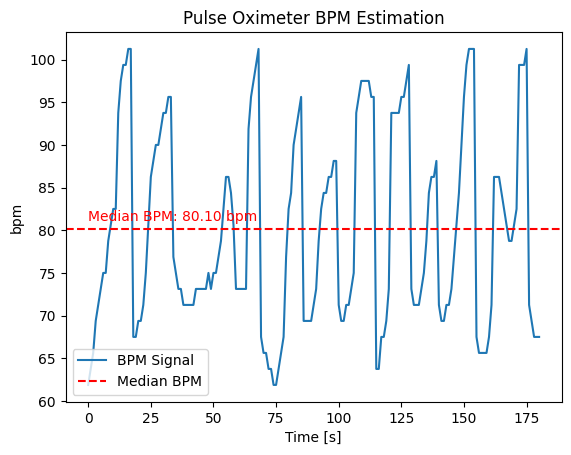

In [79]:
from pyVHR.extraction.utils import *
from scipy.signal import welch
from pyVHR.BPM.utils import Welch

timesGT = np.load(f'timesGT_w10_s{s}_T{T}_{dt}.npy')      #it is representing T3, my mistake..
bpmGT = np.load(f'bpmGT_w10_s{s}_T{T}_{dt}.npy')
fps = np.load(f'fps_w10_s{s}_T{T}_{dt}.npy')
bvpsGT = np.load(f'bvpsGT_w10_s{s}_T{T}_{dt}.npy')

bpm_avg_gt = np.average(bpmGT)
print('Average Pulse Oximeter BPM: ', bpm_avg_gt, 'bpm')
plt.plot(bpmGT, label='BPM Signal')
plt.axhline(y=bpm_avg_gt, color='red', linestyle='--', label='Median BPM')
plt.text(0.1, bpm_avg_gt+1, f'Median BPM: {bpm_avg_gt:.2f} bpm', color='red')
plt.title('Pulse Oximeter BPM Estimation')
plt.xlabel('Time [s]')
plt.ylabel('bpm')
plt.legend()
plt.show()

## NORMALIZING Median BPM Estimation..
bpmGT = normalize_rppg(bpmGT)

# Saving RGB Signal Lists from Pipeline..

In [80]:
import pickle

with open(f'filtered_windowed_sig_w10_s{s}_T{T}_{dt}.pkl', 'rb') as file:
    loaded_filtered_windowed_sig = pickle.load(file)

filtered_windowed_sig = np.array(loaded_filtered_windowed_sig)
print('Shape of filtered_windowed_sig: ', filtered_windowed_sig.shape)

with open(f'windowed_sig_w10_s{s}_T{T}_{dt}.pkl', 'rb') as file:
    loaded_windowed_sig = pickle.load(file)

windowed_sig = np.array(loaded_windowed_sig)


with open(f'sig_w10_s{s}_T{T}_{dt}.pkl', 'rb') as file:
    loaded_rgb_sig = pickle.load(file)

rgb_sig = np.array(loaded_windowed_sig)


with open(f'timesES_w10_s{s}_T{T}_{dt}.pkl', 'rb') as file:
    loaded_timesES = pickle.load(file)

timesES = loaded_timesES

Shape of filtered_windowed_sig:  (171, 1, 3, 352)


# Extracting BPM, with LGI algorithm

In [106]:
from pyVHR.BVP.methods import *
from pyVHR.BVP import *
from sklearn.decomposition import TruncatedSVD
from pyVHR.BPM.BPM import *
from pyVHR.utils.errors import *
from importlib import import_module
from pyVHR.extraction.utils import *
from scipy.signal import welch
import time
from dtw import *
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis


runtime_LGI = np.zeros(10)

for i in range(10):
    method = cpu_LGI
    
    bvps = []
    start = time.time()
    for sig in filtered_windowed_sig:    # there are 6 signals into the windowed signal due to the window size..
    
        copy_signal = np.copy(sig)  #shape [1,3,fps*wsize]
        bvp = np.zeros((0, 1), dtype=np.float32)
        bvp = signals_to_bvps_cpu(copy_signal, method)
        bvps.append(bvp)

    end = time.time()
    runtime_LGI[i] = (end-start)
    
    ## POST FILTERING..
    module = import_module('pyVHR.BVP.filters')
    method_to_call = getattr(module, 'BPfilter')
    bvps = apply_filter(bvps, 
                        method_to_call, 
                        fps=fps, 
                        params={'minHz':0.65, 'maxHz':4.0, 'fps':'adaptive', 'order':6})
    
    
    ##EXTRACTING POWER SPECTRAL DENSITY for BPM ANALYSIS..
    b = np.array(bvps)  #b.shape = (171,1,352)
    b = b.reshape(171, 352)
    Pfreqs, Power = Welch(b, fps)


    bpmES_LGI = BVP_to_BPM(bvps, fps, minHz=0.65, maxHz=4.0)
    median_bpmES_LGI, mad_bpmES_LGI = multi_est_BPM_median(bpmES_LGI)

    bpm_avg_LGI = np.average(median_bpmES_LGI)

    ##NORMALIZING Median BPM Estimation..
    median_bpmES_LGI = normalize_rppg(median_bpmES_LGI)
    
    
    if type(median_bpmES_LGI) == list:
        median_bpmES_LGI = np.expand_dims(median_bpmES_LGI, axis=0)
    if type(median_bpmES_LGI) == np.ndarray:
        if len(median_bpmES_LGI.shape) == 1:
            median_bpmES_LGI = np.expand_dims(median_bpmES_LGI, axis=0)
    

    RMSE_LGI = RMSEerror(median_bpmES_LGI, bpmGT, timesES, timesGT)
    PCC_LGI = PearsonCorr(median_bpmES_LGI, bpmGT, timesES, timesGT)
   

    ## EXTRACTING DTW (Dynamic Time Warping) Similarity Value
    median_bpmES_LGI_1D = median_bpmES_LGI.reshape(-1)
    path = dtw.warping_path(median_bpmES_LGI_1D, bpmGT)
    dtwvis.plot_warping(median_bpmES_LGI_1D, bpmGT, path, filename="warp_SVD.png")
    distance = dtw.distance(median_bpmES_LGI_1D, bpmGT)
    

print('Average Runtime: ', np.average(runtime_LGI), 'seconds')
print('Similarity DTW: ', distance) #The lower, the more similar!!
path = np.array(path)
print('RMSE LGI: ', RMSE_LGI)

## Extract average BPM..
Pmax = np.argmax(Power, axis=1) #Pmax.shape = 171 [windows]
Pfreq = Pfreqs[Pmax]
bpm_avg_LGI = np.average(Pfreq)
dBPM_LGI = np.abs(bpm_avg_gt-bpm_avg_LGI)
print('BPM_LGI: ', bpm_avg_LGI, 'bpm')
print('delta_BPM: ', dBPM_LGI, 'bpm')
plt.plot(Pfreq, label='BPM Signal')
plt.axhline(y=np.average(Pfreq), color='red', linestyle='--', label='Median BPM')
plt.text(0.1, np.average(Pfreq)+2, f'Median BPM: {np.average(Pfreq):.2f} bpm', color='red')
plt.title('BPM Estimation with LGI')
plt.xlabel('Time [s]')
plt.ylabel('bpm')
plt.legend()
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(path[:, 0], path[:, 1], '-o', label='DTW Path')
plt.title('DTW 2D Curve')
plt.xlabel('Index in rPPG Signal')
plt.ylabel('Index in PPG Signal')
plt.legend()
plt.show()

# Extracting BPM, with LGI_TruncatedSVD

Average Runtime: 0.37431888580322265 seconds
Similarity DTW:  2.000265644475771
RMSE LGI_TruncatedSVD:  [0.39602441]
BPM_LGI_TruncatedSVD:  75.47373634472228 bpm
delta_BPM:  4.62294873815064 bpm


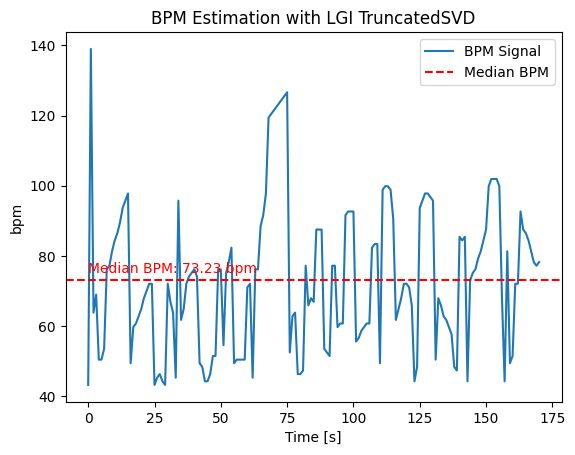

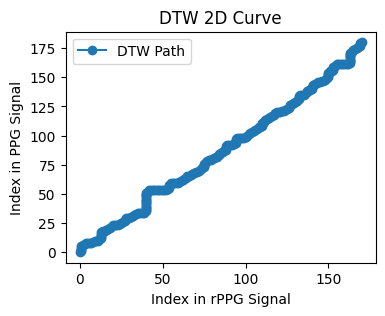

In [82]:
from pyVHR.BVP.methods import *
from pyVHR.BVP import *
from sklearn.decomposition import TruncatedSVD
from pyVHR.BPM.BPM import *
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

runtime_LGI_mod = np.zeros(10)

for i in range(10):

    method = cpu_LGI_TSVD
    params = {'Stress':'False'}

    bvps = []
    start = time.time()
    for sig in filtered_windowed_sig:    # there are 6 signals into the windowed signal due to the window size..

        copy_signal = np.copy(sig)
        #print(copy_signal.shape)
        bvp = np.zeros((0, 1), dtype=np.float32)
        bvp = signals_to_bvps_cpu(copy_signal, method, params=params)
        bvps.append(bvp)

    end = time.time()
    runtime_LGI_mod[i] = (end-start)


    # POST FILTERING..
    module = import_module('pyVHR.BVP.filters')
    method_to_call = getattr(module, 'BPfilter')
    bvps = apply_filter(bvps, 
                        method_to_call, 
                        fps=fps, 
                        params={'minHz':0.65, 'maxHz':4.0, 'fps':'adaptive', 'order':6})
  

    ## EXTRACTING POWER SPECTRAL DENSITY..
    #b = np.array(bvps)  #b.shape = (171,1,352)
    #b = b.reshape(171, 352)
    #Pfreqs, Power = Welch(b, fps)


    bpmES_LGI_mod = BVP_to_BPM(bvps, fps, minHz=0.65, maxHz=4.0)
    median_bpmES_LGI_mod, mad_bpmES_LGI_mod = multi_est_BPM_median(bpmES_LGI_mod)
    bpm_avg_LGI_mod = np.average(median_bpmES_LGI_mod)


    ## NORMALIZING Median BPM Estimation..
    median_bpmES_LGI_mod = normalize_rppg(median_bpmES_LGI_mod)

    if type(median_bpmES_LGI_mod) == list:
        median_bpmES_LGI_mod = np.expand_dims(median_bpmES_LGI_mod, axis=0)
    if type(median_bpmES_LGI_mod) == np.ndarray:
        if len(median_bpmES_LGI_mod.shape) == 1:
            median_bpmES_LGI_mod = np.expand_dims(median_bpmES_LGI_mod, axis=0)

    RMSE_LGI_mod = RMSEerror(median_bpmES_LGI_mod, bpmGT, timesES, timesGT)
    PCC_LGI_mod = PearsonCorr(median_bpmES_LGI_mod, bpmGT, timesES, timesGT)
    
    ## EXTRACTING DTW (Dynamic Time Warping) Similarity Value
    median_bpmES_LGI_mod_1D = median_bpmES_LGI_mod.reshape(-1)
    path_mod = dtw.warping_path(median_bpmES_LGI_mod_1D, bpmGT)
    dtwvis.plot_warping(median_bpmES_LGI_mod_1D, bpmGT, path, filename="warp_TSVD.png")
    distance_mod = dtw.distance(median_bpmES_LGI_mod_1D, bpmGT)
    

print('Average Runtime:', np.average(runtime_LGI_mod), 'seconds')
print('Similarity DTW: ', distance_mod)
path = np.array(path_mod)
print('RMSE LGI_TruncatedSVD: ', RMSE_LGI_mod)

## Extract average BPM..
#Pmax = np.argmax(Power, axis=1) #Pmax.shape = 171 [windows]
#Pfreq = Pfreqs[Pmax]
#bpm_avg_LGI_mod = np.average(Pfreq)
dBPM_LGI_mod = np.abs(bpm_avg_gt-bpm_avg_LGI_mod)
print('BPM_LGI_TruncatedSVD: ', bpm_avg_LGI_mod, 'bpm')
print('delta_BPM: ', dBPM_LGI_mod, 'bpm')

plt.plot(Pfreq, label='BPM Signal')
plt.axhline(y=np.average(Pfreq), color='red', linestyle='--', label='Median BPM')
plt.text(0.1, np.average(Pfreq)+2, f'Median BPM: {np.average(Pfreq):.2f} bpm', color='red')
plt.title('BPM Estimation with LGI TruncatedSVD')
plt.xlabel('Time [s]')
plt.ylabel('bpm')
plt.legend()
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(path[:, 0], path[:, 1], '-o', label='DTW Path')
plt.title('DTW 2D Curve')
plt.xlabel('Index in rPPG Signal')
plt.ylabel('Index in PPG Signal')
plt.legend()
plt.show()

# LGI vs Truncated-LGI

In [105]:
plt.plot(timesGT, bpmGT, label='Pulse Oximeter PPG (Ground Truth)')


if type(median_bpmES_LGI) == list:
    median_bpmES_LGI = np.squeeze(median_bpmES_LGI, axis=0)
if type(median_bpmES_LGI) == np.ndarray:
    if len(median_bpmES_LGI.shape) == 2:
        median_bpmES_LGI = np.squeeze(median_bpmES_LGI)


if type(median_bpmES_LGI_mod) == list:
    median_bpmES_LGI_mod = np.squeeze(median_bpmES_LGI_mod, axis=0)
if type(median_bpmES_LGI_mod) == np.ndarray:
    if len(median_bpmES_LGI_mod.shape) == 2:
        median_bpmES_LGI_mod = np.squeeze(median_bpmES_LGI_mod)

plt.plot(timesES, median_bpmES_LGI, label=[('LGI, error DTW=', distance), 'dBPM=', delta_BPM])
#plt.plot(timesES, median_bpmES_LGI_mod, label=('LGI TSVD rPPG, error DTW=', np.round(distance_mod, 2)))
plt.xlabel('Time [s]')
plt.ylabel('rPPG Signal')
plt.title('LGI TruncatedSVD')
plt.legend()
plt.show()

SyntaxError: positional argument follows keyword argument (378909180.py, line 17)